In [8]:
%matplotlib inline

from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import pandas as pd
import numpy as np 

In [3]:
model_location = '/home/sage/ml_playground/catsvsdogs/trained/keras/vgg16_cat_dog_retrained.json'
weights_location = '/home/sage/ml_playground/catsvsdogs/trained/keras/vgg16_cat_dog_retrained.h5'

with open(model_location, 'r') as myfile:
    model_json = myfile.read()

model = model_from_json(model_json)
model.load_weights(weights_location)

In [4]:
validation_data_dir = '/home/sage/ml_playground/catsvsdogs/PetImages/val'
img_width, img_height = 224, 224

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory=validation_data_dir,
                                                              target_size=[img_width, img_height],
                                                              batch_size=1,
                                                              class_mode='categorical')

Found 1240 images belonging to 2 classes.


In [12]:
sample,_ = next(validation_generator)

In [10]:
model_no_classifier = Model(inputs=model.input, outputs=model.get_layer('fc1').output)

In [14]:
prediction = model_no_classifier.predict(sample)

In [17]:
prediction.shape

(1, 1024)

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 6)

{'cat': 4.0261551e-05, 'dog': 0.99995971}


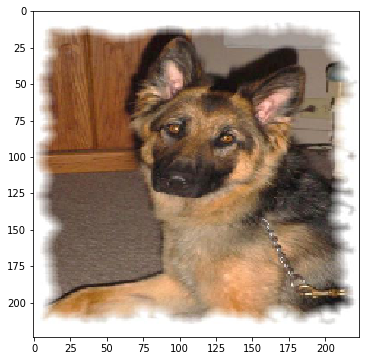

In [17]:
X_val_sample, _ = next(validation_generator)

y_pred = model.predict(X_val_sample)

img = 256. - X_val_sample[0] ## vgg images end up being negatives for some reason

print({'cat': y_pred[0][0], 'dog': y_pred[0][1]})
plt.imshow(img)

In [19]:
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay, visualize_cam, visualize_activation
from keras import activations

In [20]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/home/sage/envs/playground/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


0
[[ 8.91770935 -5.0461607 ]]


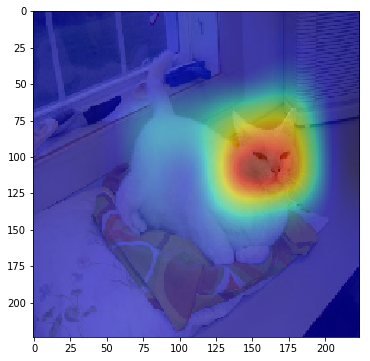

In [30]:
sample, _ = next(validation_generator)
y_pred = model.predict(sample)

predicted = np.argmax(y_pred[0])

print(predicted)
print(y_pred)

grads = visualize_cam(model, layer_idx, filter_indices=predicted, seed_input=sample, backprop_modifier='relu')

plt.imshow(overlay(grads, sample[0]))

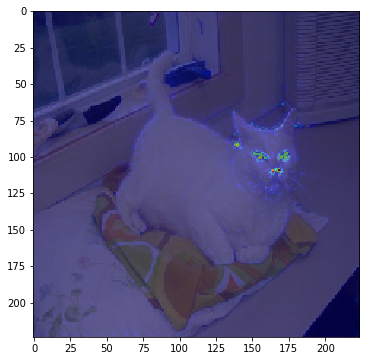

In [31]:
grads = visualize_saliency(model, layer_idx, filter_indices=predicted, seed_input=sample, backprop_modifier='guided')
plt.imshow(overlay(grads, sample[0]))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


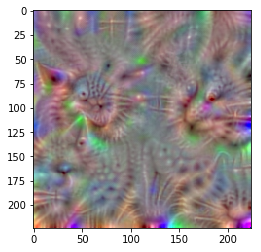

In [116]:
img = visualize_activation(model, layer_idx, filter_indices=0)
plt.imshow(img)

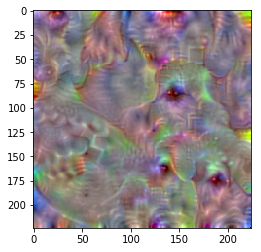

In [117]:
img = visualize_activation(model, layer_idx, filter_indices=1)
plt.imshow(img)

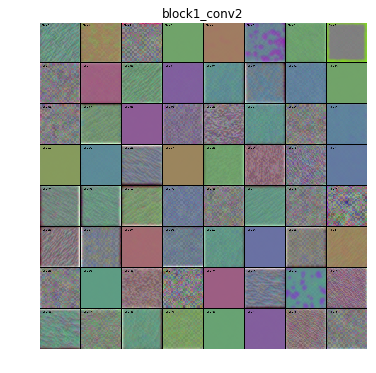

In [120]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()